## Lab | Making predictions with logistic regression
#### In this lab, you will be using the Sakila database of movie rentals.

#### In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

#### Instructions

#### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

#### Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

#### Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

#### Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

#### Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
#### Evaluate the results.

In [81]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [82]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila' #/bank = Name of Database
engine = create_engine(connection_string)

query  = '''SELECT DISTINCT f. film_id, f. title, rental_duration, length, rating, rental_rate, 
SUM(
	CASE
		WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1
        else 0
	END) AS rented_in_may
FROM sakila.film f
LEFT JOIN sakila.inventory i
USING (film_id) 
LEFT JOIN sakila.rental r 
on i.inventory_id = r.inventory_id
GROUP BY f.film_id;'''


data = pd.read_sql_query(query, engine)

display(data)


,film_id,title,rental_duration,length,rating,rental_rate,rented_in_may
0,1,ACADEMY DINOSAUR,6,86,PG,0.99,2.0
1,2,ACE GOLDFINGER,3,48,G,4.99,0.0
2,3,ADAPTATION HOLES,7,50,NC-17,2.99,0.0
3,4,AFFAIR PREJUDICE,5,117,G,2.99,1.0
4,5,AFRICAN EGG,6,130,G,2.99,1.0
...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,6,183,G,0.99,0.0
996,997,YOUTH KICK,4,179,NC-17,0.99,0.0
997,998,ZHIVAGO CORE,6,105,NC-17,0.99,1.0
998,999,ZOOLANDER FICTION,5,101,R,2.99,1.0


In [83]:
def boolean(x):
    if x>=1:
        return 1
    else:
        return 0
data['rented_in_may'] = list(map(boolean, data['rented_in_may']))

In [84]:
data.head(5)

,film_id,title,rental_duration,length,rating,rental_rate,rented_in_may
0,1,ACADEMY DINOSAUR,6,86,PG,0.99,1
1,2,ACE GOLDFINGER,3,48,G,4.99,0
2,3,ADAPTATION HOLES,7,50,NC-17,2.99,0
3,4,AFFAIR PREJUDICE,5,117,G,2.99,1
4,5,AFRICAN EGG,6,130,G,2.99,1


In [85]:
data.dtypes

film_id              int64
title               object
rental_duration      int64
length               int64
rating              object
rental_rate        float64
rented_in_may        int64
dtype: object

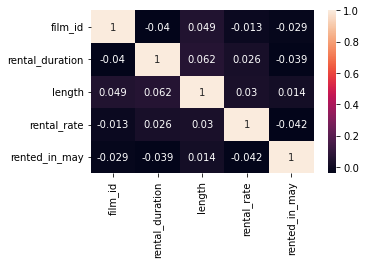

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix=data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [87]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data['rented_in_may']
X = data.drop(['rented_in_may', 'title'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [88]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,film_id,rental_duration,length,rental_rate
0,0.046092,0.50,0.769784,1.0
1,0.790581,0.75,0.151079,0.0
2,0.723447,0.00,0.258993,0.5
3,0.283567,0.50,0.223022,1.0
4,0.039078,0.25,0.733813,0.0
...,...,...,...,...
795,0.167335,0.50,0.151079,0.0
796,0.232465,0.00,0.683453,0.0
797,0.861723,0.00,0.467626,1.0
798,0.189379,0.50,0.906475,1.0


In [89]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,film_id,rental_duration,length,rental_rate
0,0.046092,0.50,0.769784,1.0
1,0.790581,0.75,0.151079,0.0
2,0.723447,0.00,0.258993,0.5
3,0.283567,0.50,0.223022,1.0
4,0.039078,0.25,0.733813,0.0


In [90]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset
from sklearn.compose import make_column_transformer

encoder = OneHotEncoder(drop='first').fit(X_train_cat) 

cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

X_train_cat_encode = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=cols)

display(X_train_cat_encode.head())
X_train_cat_encode.shape

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


(800, 4)

In [91]:
X_train_transformed = pd.concat([X_train_norm, X_train_cat_encode], axis=1)

In [92]:
X_train_transformed

,film_id,rental_duration,length,rental_rate,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.046092,0.50,0.769784,1.0,1.0,0.0,0.0,0.0
1,0.790581,0.75,0.151079,0.0,0.0,0.0,1.0,0.0
2,0.723447,0.00,0.258993,0.5,0.0,0.0,1.0,0.0
3,0.283567,0.50,0.223022,1.0,1.0,0.0,0.0,0.0
4,0.039078,0.25,0.733813,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
795,0.167335,0.50,0.151079,0.0,0.0,0.0,0.0,1.0
796,0.232465,0.00,0.683453,0.0,0.0,1.0,0.0,0.0
797,0.861723,0.00,0.467626,1.0,0.0,0.0,0.0,1.0
798,0.189379,0.50,0.906475,1.0,1.0,0.0,0.0,0.0


In [93]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='auto').fit(X_train_transformed, y_train)

In [94]:
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)
# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [95]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat) 

cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

X_test_cat_encode = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns=cols)

display(X_test_cat_encode.head())
X_test_cat_encode.shape

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0


(200, 4)

In [96]:
X_test_transformed = pd.concat([X_test_norm, X_test_cat_encode], axis=1)

In [97]:
X_test_transformed

,0,1,2,3,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.978958,0.00,0.374101,0.0,0.0,0.0,0.0,1.0
1,0.015030,0.75,0.964029,0.5,1.0,0.0,0.0,0.0
2,0.056112,0.25,0.316547,0.5,0.0,0.0,1.0,0.0
3,0.802605,1.00,0.618705,0.5,0.0,1.0,0.0,0.0
4,0.748497,0.25,0.453237,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
195,0.737475,0.25,0.402878,0.0,0.0,0.0,0.0,0.0
196,0.369739,0.25,0.446043,0.5,0.0,0.0,0.0,1.0
197,0.470942,1.00,0.273381,0.5,1.0,0.0,0.0,0.0
198,0.807615,0.25,0.294964,0.0,1.0,0.0,0.0,0.0


In [98]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.63

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  0,  74],
       [  0, 126]], dtype=int64)

In [100]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.54